<a href="https://colab.research.google.com/github/FE-Dev-Dharunkkumar/Paddy-Leaf-Disease/blob/main/Paddy%20Leaf%20Disease%20Classification%20Using%20Deep%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip install -U tensorflow-addons

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                              title                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------  ----------------------------------  -----  -------------------  -------------  ---------  ---------------  
zain280/car-dataset                              Car Dataset                           1MB  2024-03-02 15:14:49           1566         25  1.0              
syedanwarafridi/vehicle-sales-data               Vehicle Sales Data                   19MB  2024-02-21 20:16:17           7815        135  1.0              
mahad049/job-placement-dataset                   Job placement dataset                 6KB  2024-03-03 08:18:12            923         25  0.9411765        
yaminh/smartphone-sale-dataset                   Smartphones Sales Dataset            65KB  2024-03-03 16:48:27           1024         22  0.88235295       
tarunrm09/climate-change-indicators              Climate c

In [ ]:
! kaggle competitions download -c 'paddy-disease-classification'

 99% 1.01G/1.02G [00:15<00:00, 47.1MB/s]
100% 1.02G/1.02G [00:15<00:00, 69.9MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('paddy-disease-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import random
from tqdm import tqdm
from pathlib import Path
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, optimizers, losses, metrics, callbacks, initializers
from tensorflow.keras import Sequential, Model, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, MobileNetV2, VGG16
from sklearn.model_selection import train_test_split
#import tensorflow_addons as tfa

from tensorflow.keras.utils import plot_model

from PIL import Image
import warnings
warnings.filterwarnings("ignore")
random.seed(45)

print(tf.__version__)

2.15.0


In [ ]:
import glob
import os
from tqdm import tqdm
from PIL import  Image, ImageFile
from joblib  import Parallel, delayed
import shutil
ImageFile.LOAD_TRUNCATED_IMAGES = True

**LOAD IMAGE DATA AND UNDERSTANDING SOME PROPERTIES OF IMAGE**

In [ ]:
def image_properties(path):
    for img in random.sample(os.listdir(path),1):
        print('Image name =',img)
        image = cv.imread(os.path.join(path, img),cv.IMREAD_COLOR)
        break

    return image

Image name = 107159.jpg
The dimensions are 640 pixels height and 480 pixels width
The maximum pixel value is 255.00
The minimum pixel value is 0.00
The mean value of the pixels is 118.40
The standard deviation is 70.80


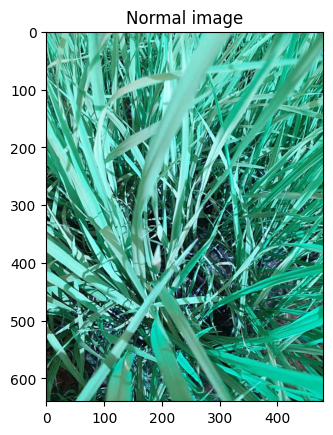

In [ ]:
path = '/content/train_images/normal'

image = image_properties(path)
plt.imshow(image)
plt.title('Normal image')
print(f"The dimensions are {image.shape[0]} pixels height and {image.shape[1]} pixels width")
print(f"The maximum pixel value is {image.max():.2f}")
print(f"The minimum pixel value is {image.min():.2f}")
print(f"The mean value of the pixels is {image.mean():.2f}")
print(f"The standard deviation is {image.std():.2f}")

**Loading a dataset**

In [ ]:
batch_size = 64
img_height = 256
img_width =  256

data_dir = '/content/train_images'

**Image Data-Generator**

**Data Normalization And Data Augmentation**

In [ ]:
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                            rescale=1.0/255.0,
                            validation_split=0.3,
                            rotation_range=5,
                            shear_range=0.3,
                            zoom_range=0.3,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True
                )

**Training Dataset (70%)**

In [ ]:
train_gen = img_datagen.flow_from_directory(
                            data_dir,
                            subset="training",
                            seed=42,
                            target_size=(img_height, img_width),
                            batch_size=batch_size,
                            class_mode="categorical",
                            color_mode='rgb'
            )

Found 7288 images belonging to 10 classes.


**Testing Dataset (30%)**

In [ ]:
valid_gen = img_datagen.flow_from_directory(
                            data_dir,
                            subset="validation",
                            seed=42,
                            target_size=(img_height, img_width),
                            batch_size=batch_size,
                            class_mode="categorical"
            )

Found 3119 images belonging to 10 classes.


**Class Lables**

In [ ]:
print('Total No Of Classes in the datasetL:',len(train_gen.class_indices))
print('Class Names:',train_gen.class_indices)

Total No Of Classes in the datasetL: 10
Class Names: {'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}


**Displaying a 9 Random images form dataset**

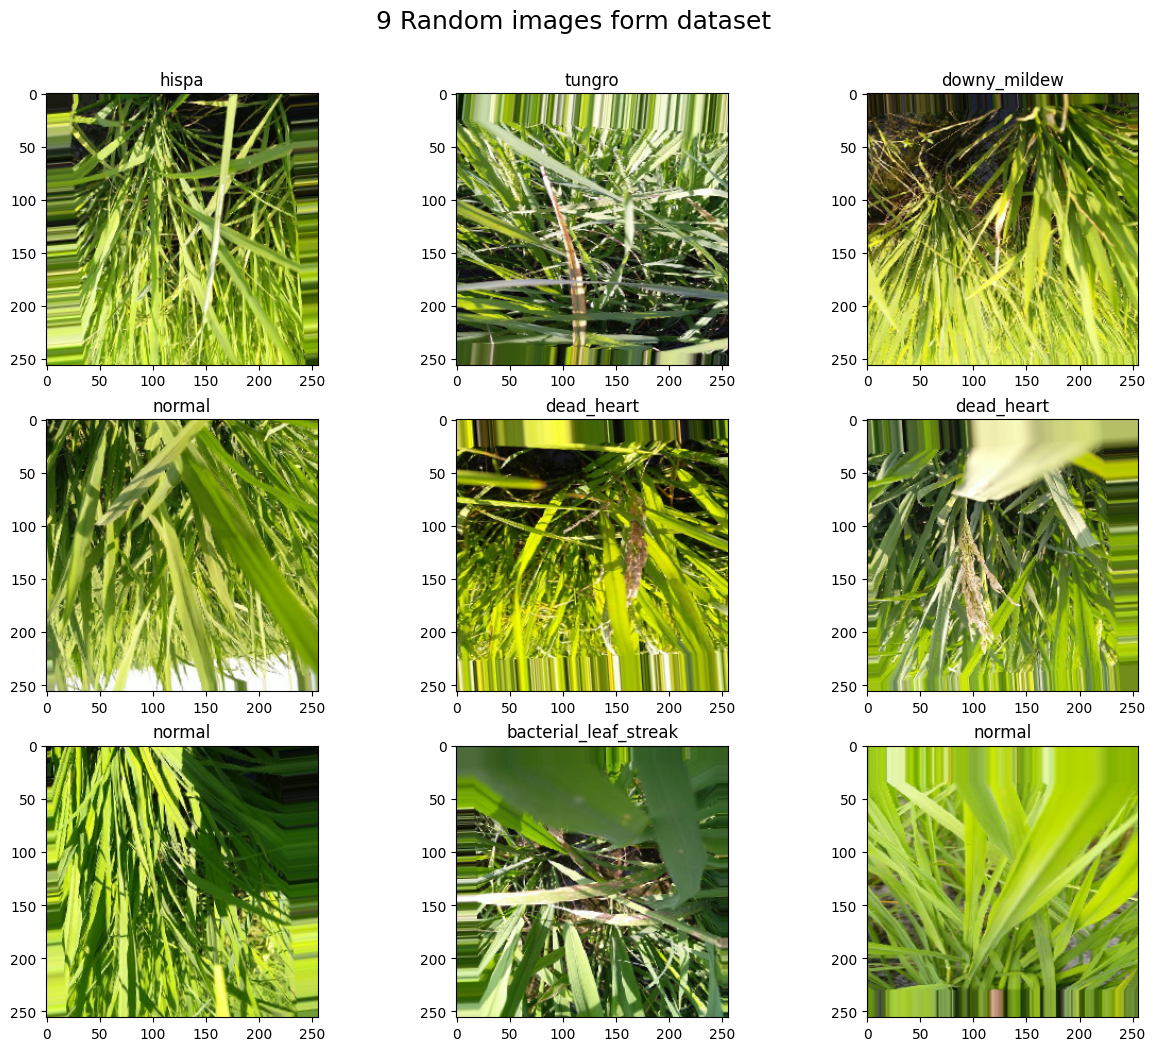

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.2)
fig.suptitle("9 Random images form dataset", fontsize=18, y=0.95)

for i in range(1,10):
    plt.subplot(3,3,i)
    img, label = train_gen.next()
    plt.title(list(train_gen.class_indices.keys())[np.argmax(label)])
    plt.imshow(img[0])

**CNN Model**

In [ ]:
num_classes = 10
input_shape = (batch_size,256,256,3)

In [ ]:
model = None
model = tf.keras.Sequential([

        tf.keras.layers.Conv2D(16, (3,3), activation='relu' ),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (64, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (64, 127, 127, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (64, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (64, 60, 60, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (64, 30, 30, 64)          0

**CallBacks**

In [ ]:
# terminate if loss was NaN
class TerminateNaN(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    loss = logs.get('loss')
    if loss is not None:
      if np.isnan(loss) or np.isinf(loss):
        print('Invalid loss and terminated at loss {}'.format(epoch))
        self.model.stop_training = True

terminate_nan = TerminateNaN()

In [ ]:
# save model after every epoch if the validation accuracy improves from previous epoch
filepath = '/content/model_vgg_new.hdf5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = filepath,
    monitor="val_categorical_accuracy",
    verbose=1,
    save_best_only=True,
    mode = 'auto'
)

In [ ]:
# learning rate scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_categorical_accuracy",
    factor=0.1,
    patience=1,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    cooldown=3,
    min_lr=0
)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)]
)

In [ ]:
history = model.fit(
    train_gen,
    batch_size = batch_size,
    validation_data = valid_gen,
    epochs=2,#20
    verbose=1,
    callbacks=[terminate_nan, checkpoint, reduce_lr]
)

Epoch 1/2
114/114 [==============================] - ETA: 0s - loss: 2.0372 - categorical_accuracy: 0.2672
Epoch 1: val_categorical_accuracy improved from -inf to 0.33729, saving model to /content/model_vgg_new.hdf5
114/114 [==============================] - 850s 7s/step - loss: 2.0372 - categorical_accuracy: 0.2672 - val_loss: 1.9227 - val_categorical_accuracy: 0.3373 - lr: 3.0000e-04
Epoch 2/2
114/114 [==============================] - ETA: 0s - loss: 1.8403 - categorical_accuracy: 0.3537
Epoch 2: val_categorical_accuracy improved from 0.33729 to 0.37256, saving model to /content/model_vgg_new.hdf5
114/114 [==============================] - 853s 7s/step - loss: 1.8403 - categorical_accuracy: 0.3537 - val_loss: 1.7907 - val_categorical_accuracy: 0.3726 - lr: 3.0000e-04


**training vs validation loss**

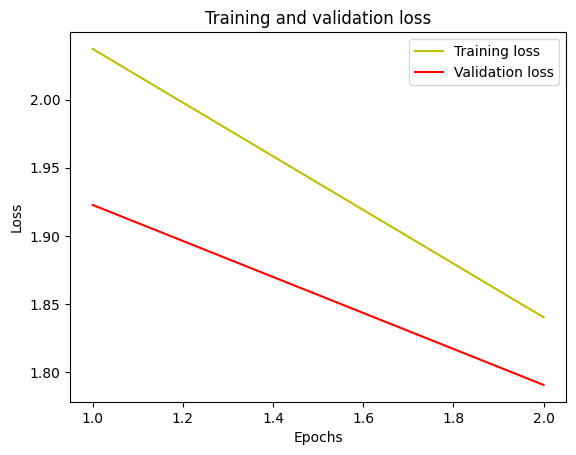

In [ ]:
history = history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Training Accuracy Vs Validation Accuracy**

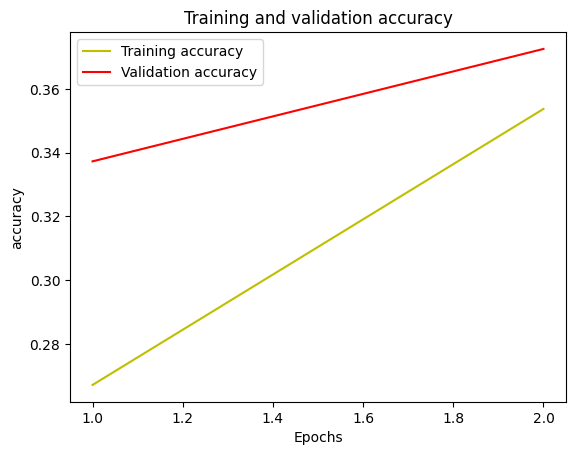

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(valid_gen)

49/49 [==============================] - 123s 2s/step - loss: 1.7915 - categorical_accuracy: 0.3713


In [ ]:
print('Validation Accuracy', accuracy)

Validation Accuracy 0.37127283215522766


**MobileNetV2**

In [ ]:
model_mobile_net = MobileNetV2(include_top = False, input_shape = (256,256,3), weights = 'imagenet')

model_mobile_net.trainable = True

inputs = Input(shape=(256,256,3))
main = model_mobile_net(inputs, training = True)

x = layers.Flatten()(main)
x = layers.Dense(256, 'relu', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(10, activation='softmax', name= 'outputs')(x)

model_mobile_net = Model(inputs= [inputs], outputs= [outputs])


model_mobile_net.compile(optimizer=optimizers.Adam(3e-4),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)],
              loss=losses.CategoricalCrossentropy(label_smoothing=0.1))

model_mobile_net.summary()

In [ ]:
history = model_mobile_net.fit(
    train_gen,
    batch_size = batch_size,
    validation_data = valid_gen,
    epochs=20,
    verbose=1,
    callbacks=[terminate_nan, checkpoint, reduce_lr]
)

In [ ]:
history = history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = model_mobile_net.history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model_mobile_net.evaluate(valid_gen)

In [ ]:
print('Validation Accuracy', accuracy)

**InceptionV3**

In [ ]:
model_inception = None
model_inception = InceptionV3(include_top = False, input_shape = (256,256,3), weights = 'imagenet')

model_inception.trainable = True

inputs = Input(shape=(256,256,3))
main = model_inception(inputs, training = True)

x = layers.Flatten()(main)
x = layers.Dense(256, 'relu', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(10, activation='softmax', name= 'outputs')(x)

model_inception = Model(inputs= [inputs], outputs= [outputs])


model_inception.compile(optimizer=optimizers.Adam(3e-4),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)],
              loss=losses.CategoricalCrossentropy(label_smoothing=0.1))

model_inception.summary()

In [ ]:
history = model_inception.fit(
    train_gen,
    batch_size = batch_size,
    validation_data = valid_gen,
    epochs=20,
    verbose=1,
    callbacks=[terminate_nan, checkpoint, reduce_lr]
)

In [ ]:
history = history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = model_inception.history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model_inception.evaluate(valid_gen)

In [ ]:
print('Validation Accuracy', accuracy)

**Vision Transformer (ViT)**

#### REF: `https://keras.io/examples/vision/image_classification_with_vision_transformer/`

In [ ]:
# loads an image and convert them to numpy array
def load_images(paths):

  data = []
  labels = []
  i = 0
  for label, path in tqdm(enumerate(paths)):
    for img_path in os.listdir(path):
      image = np.array(Image.open(os.path.join(path,img_path)).convert('RGB').resize((256,256)))
      data.append(image)
      labels.append(label)

  return np.array(data), np.asarray(labels)

In [ ]:
images, labels = load_images(glob.glob('/content/train_images/*'))

**Train Test Split (70:30)**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels.reshape(-1,1), test_size=0.33, random_state=42)

In [ ]:
num_classes = 10
input_shape = (256, 256, 3)

**Configure the hyperparameters**

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 1 #100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

**Data Augmentation**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

**multilayer perceptron (MLP)**

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

**Implementing patch creation as a layer**

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

**Implementing the patch encoding layer**

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

**ViT Model**

In [ ]:
def create_vit_classifier():

    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ]
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.3
    )

    _, accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

In [ ]:
#vit_classifier.save_weights('/content/drive/MyDrive/h/paddy_models/vit.hdf5')

In [ ]:
history = history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()